# Research Background: 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
import timeit
import helper as hlp
start_time = timeit.default_timer()
%matplotlib notebook
CSS = """
.output {
    align-items: center;
}
}
"""
HTML('<style>{}</style>'.format(CSS))

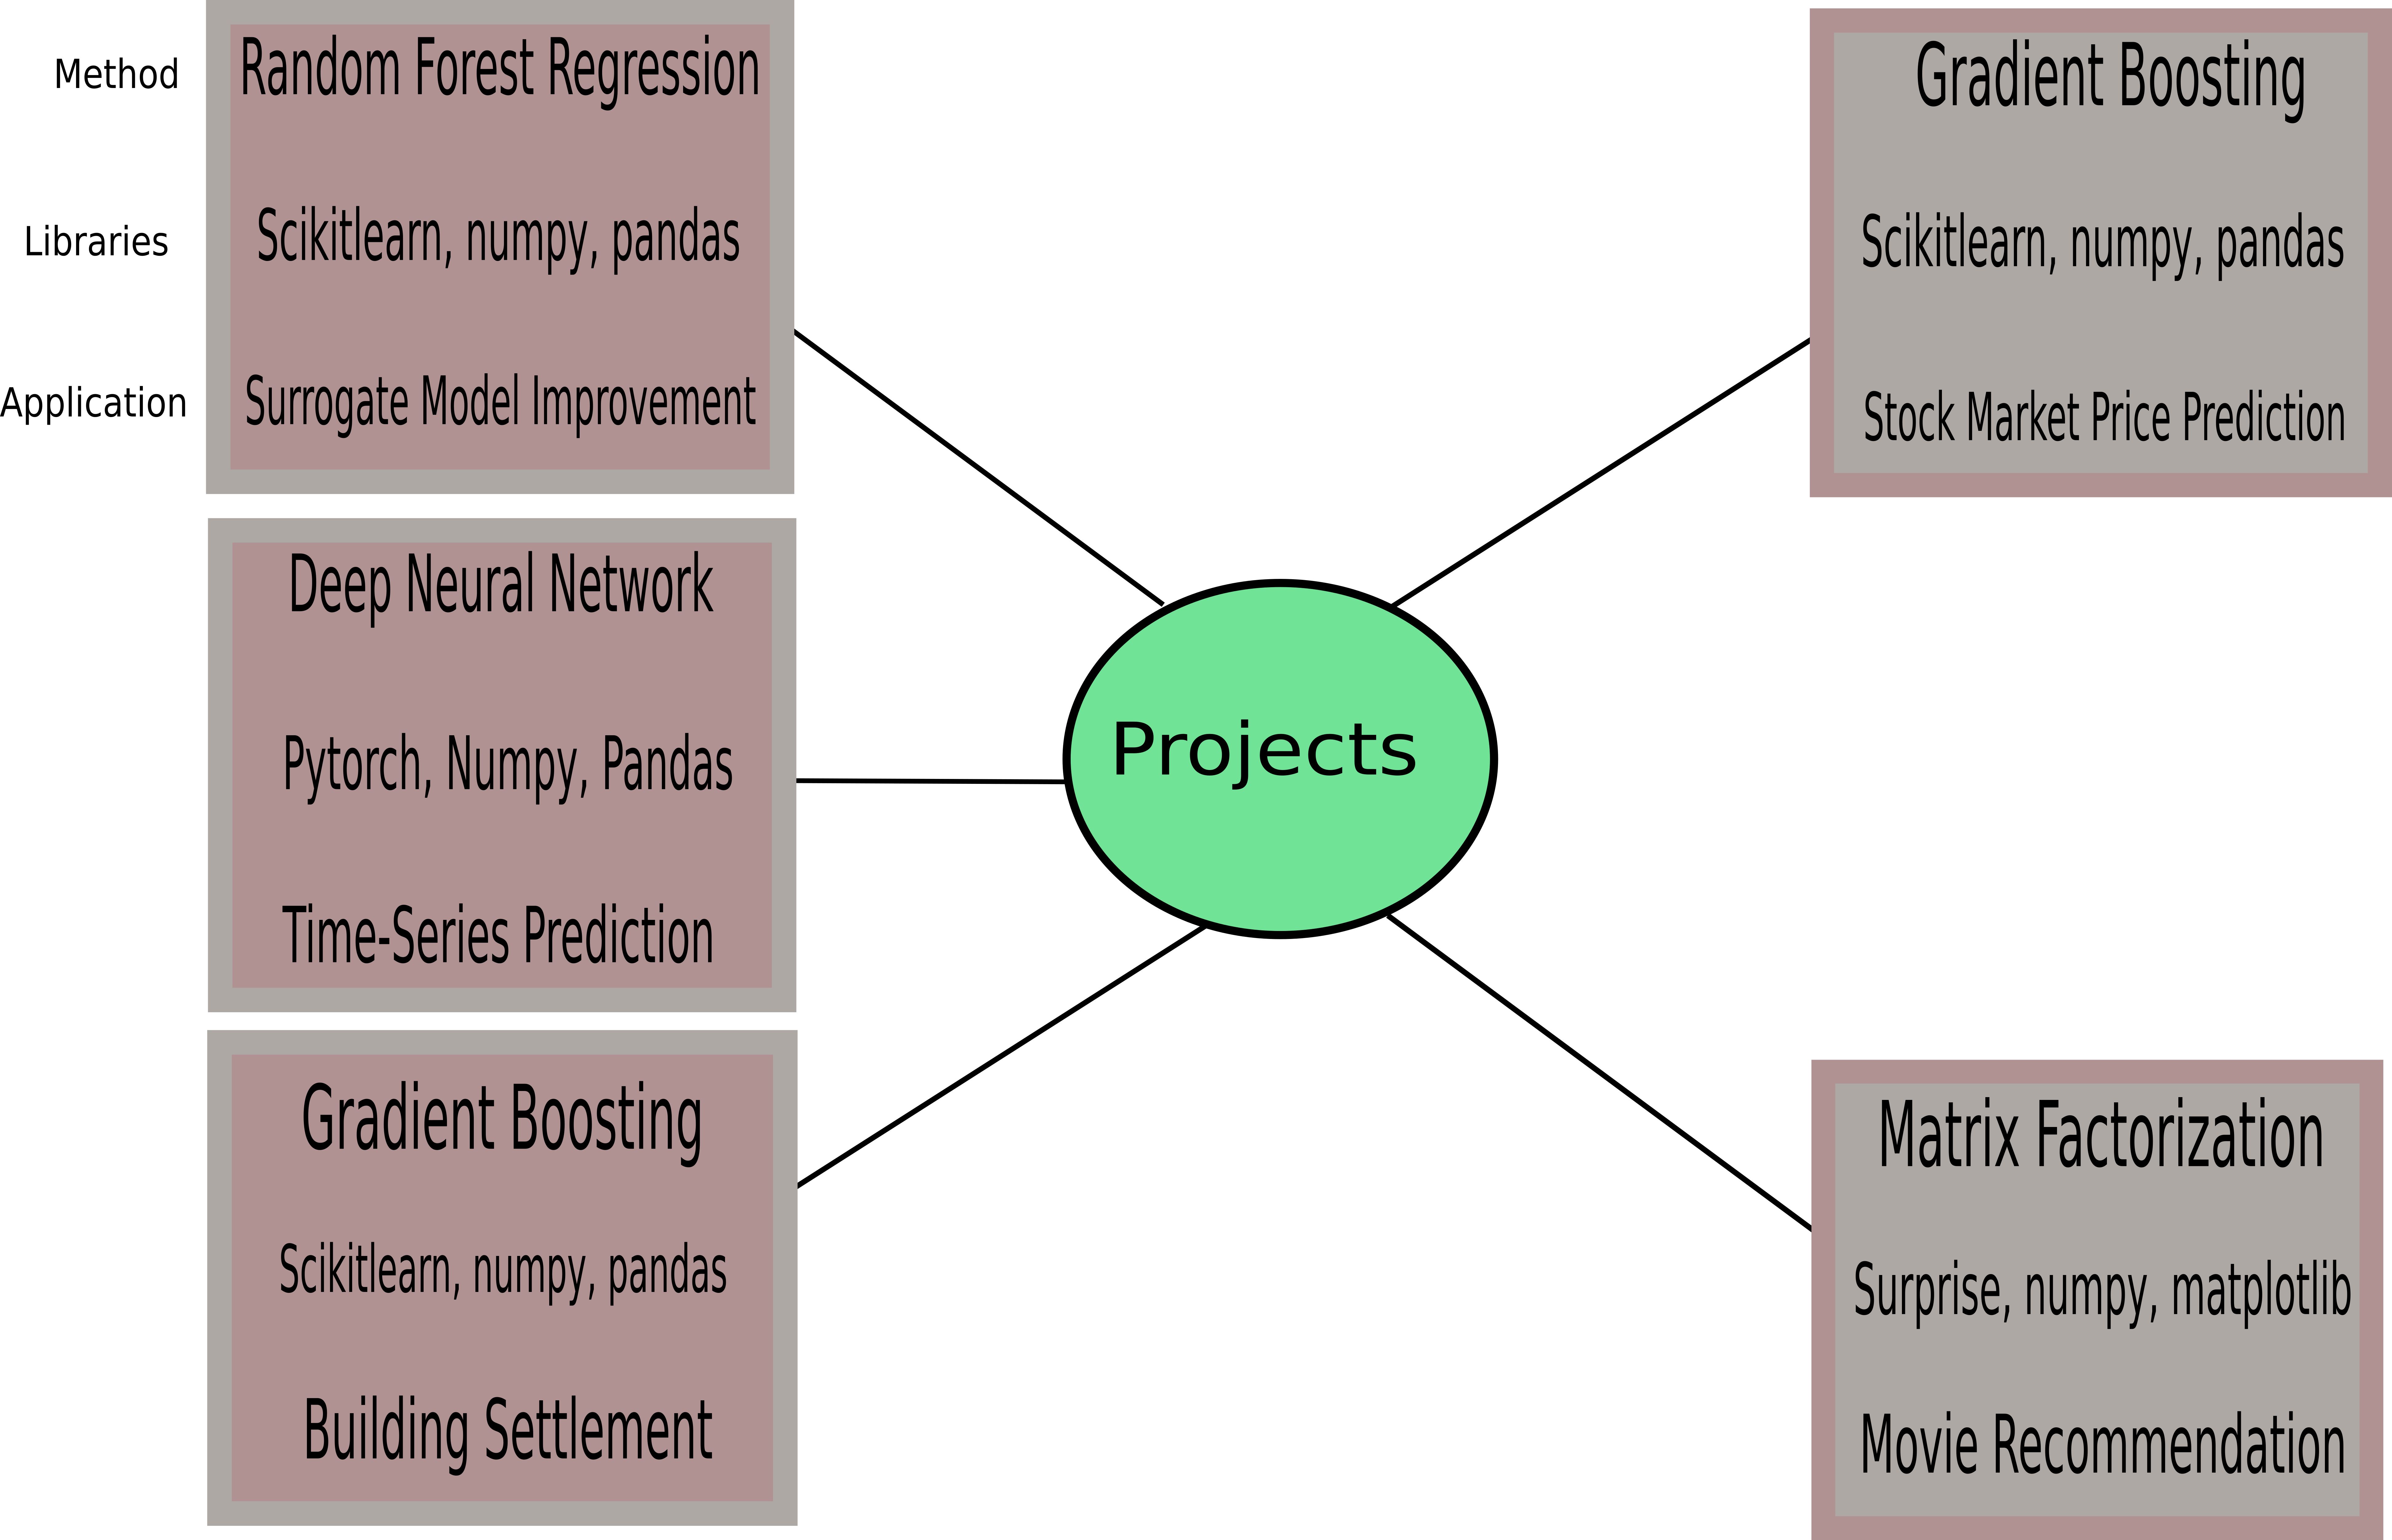

In [22]:
Image(filename='projects_overview.png', width="800")

#### Animation showing basin effects

In [69]:
HTML("""
    <video controls src="{0}" loop=1 autoplay width=150%/> 
    """.format('M8 Simulation on the San Andreas Fault.mp4')
)

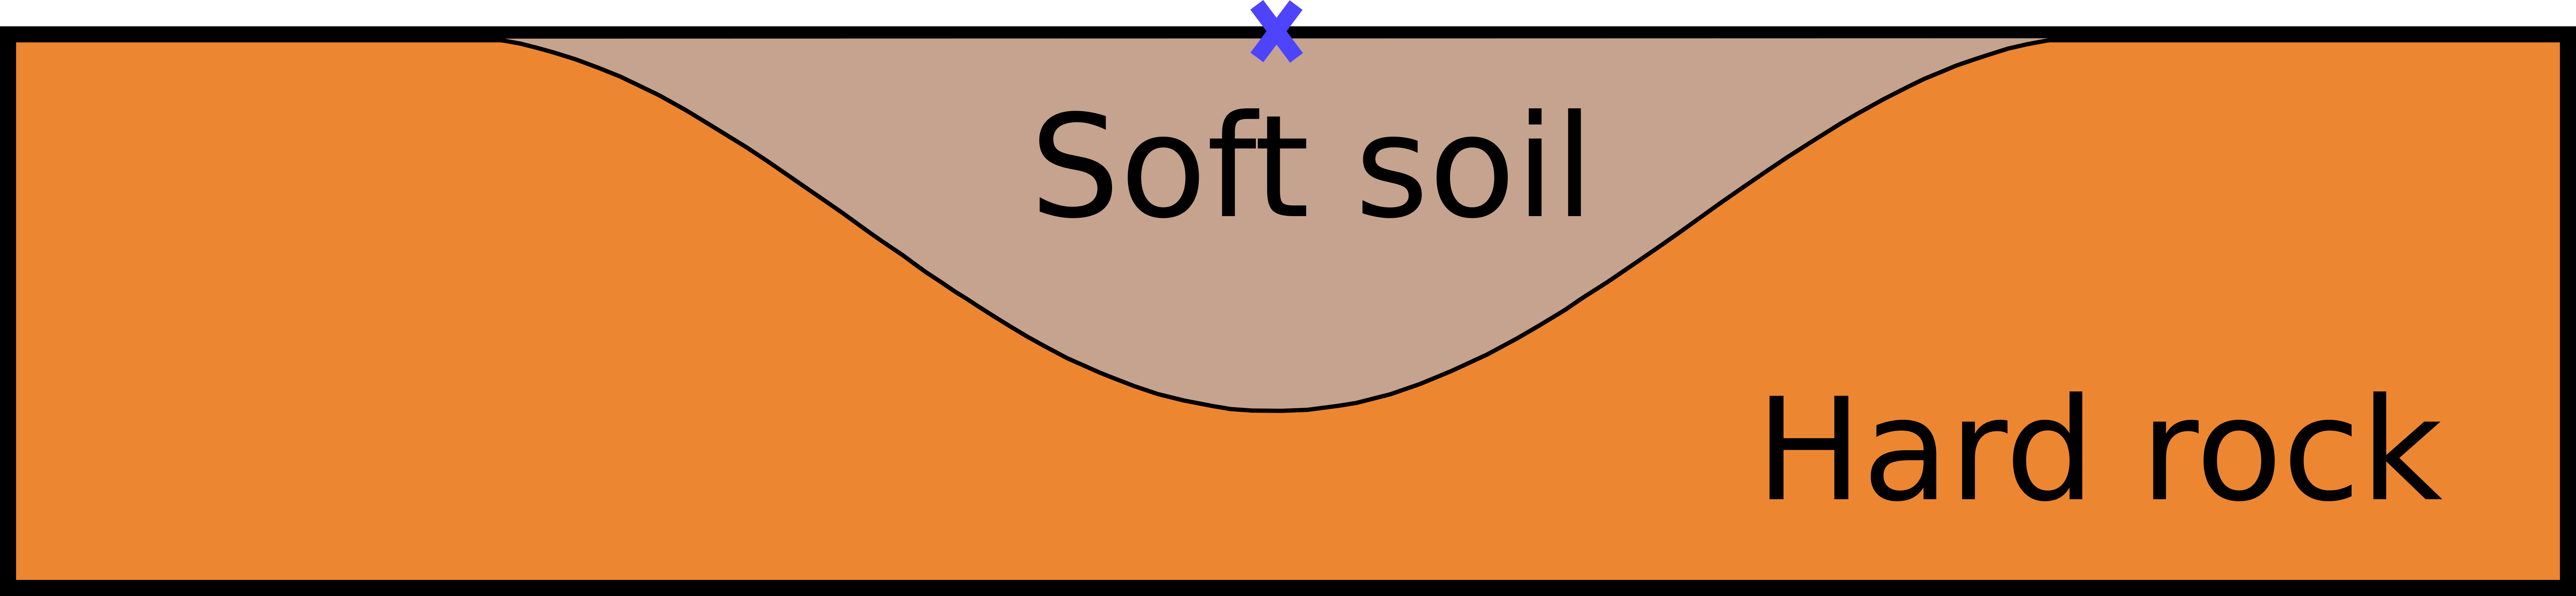

In [70]:
Image(filename='schematic_2D.png', width="800")

#### Data type: time-series 

In [25]:
dt = 0.001
time_series = np.loadtxt('time_Series')
transformed_series = hlp.fourier_transform(time_series) 

<IPython.core.display.Javascript object>


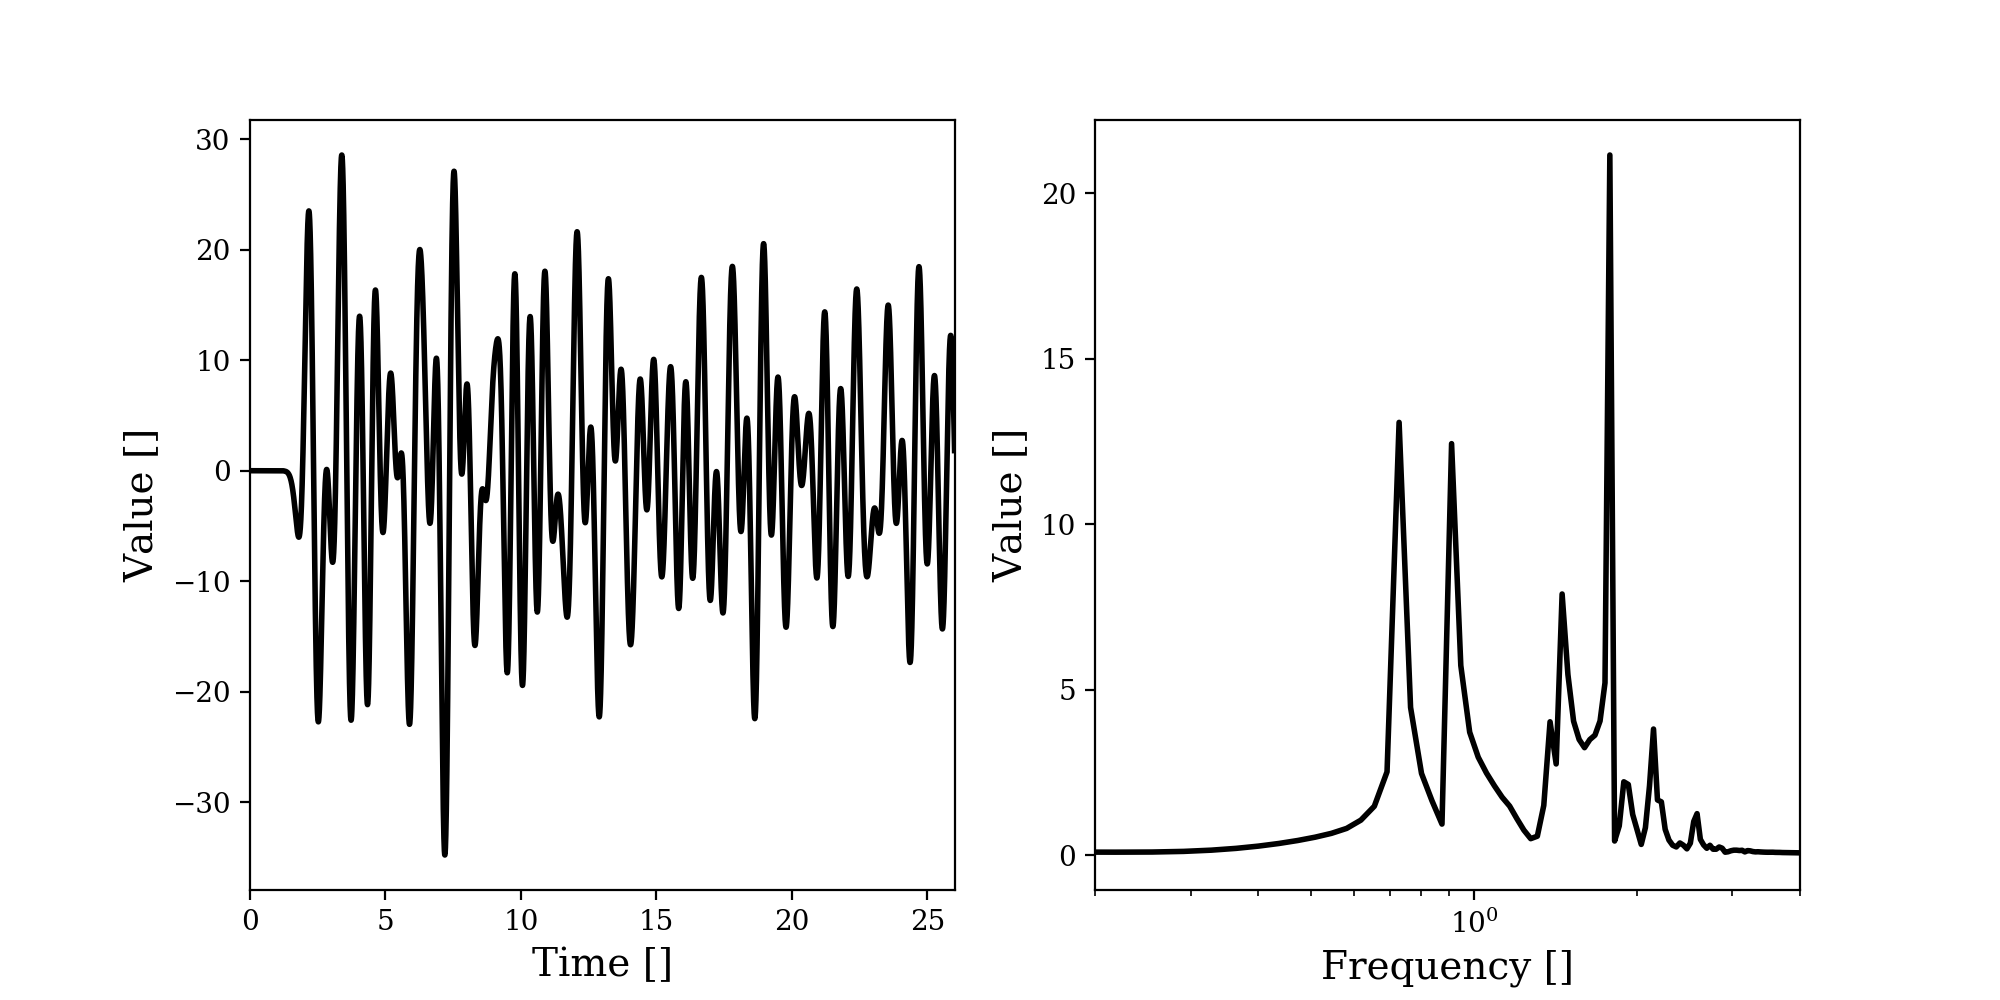

In [26]:
fig = plt.figure(figsize=(10, 5))
plt.rc('font', family='serif')

ax = fig.add_subplot(121)
plt.plot(time_series[:,0],time_series[:,1], color='k', linewidth=2)
ax.set_xlim([0,26])
ax.set_xlabel('Time []', fontsize=14)
ax.set_ylabel('Value []', fontsize=14)

ax1 = fig.add_subplot(122)
plt.rc('font', family='serif')

plt.plot(transformed_series[:,0], transformed_series[:,1]/5.812447140672383e+03, color='k', linewidth=2)
ax1.set_xlim([0.2,4])
ax1.set_xlabel('Frequency []', fontsize=14)
ax1.set_ylabel('Value []', fontsize=14)
ax1.set_xscale('log')

plt.show()

# ML: 

### Train a Deep Neural Network for a regression problem

#### Import libraries

In [40]:
import torch 
import torch.nn as nn
from torchvision import models
import matplotlib 
import torch.nn.functional as F
import pandas as pd
# from sklearn import preprocessing
from sklearn.metrics import r2_score

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

manualSeed = 42 # Set the desired seed to reproduce the results
torch.manual_seed(manualSeed)
c = 100

#### Data preprocessing 

In [41]:
Data = pd.read_csv('training_data_spectral_new.csv')
Data_tensor_normalized = Data.values
Data_tensor = torch.tensor(Data_tensor_normalized).float() 
bs = 419

#Shuffling
data_size = len(Data_tensor)
r=torch.randperm(data_size)
Data_tensor = Data_tensor[r,:]

# I am training for real part of the amplification
train_size = int(data_size*.90)
val_size = int((data_size - train_size)/2)

train_x = Data_tensor[0:train_size,0:4]
train_y_raw_re = Data_tensor[0:train_size,4:5]
train_y_raw_im = Data_tensor[0:train_size,4:5]
train_y = np.abs(np.sqrt(np.power(train_y_raw_re, 2) + np.power(train_y_raw_im, 2)))


val_x = Data_tensor[train_size:train_size+val_size,0:4]
val_y_raw_re = Data_tensor[train_size:train_size+val_size,4:5]
val_y_raw_im = Data_tensor[train_size:train_size+val_size,4:5]
val_y = np.abs(np.sqrt(np.power(val_y_raw_re, 2) + np.power(val_y_raw_im, 2)))



test_x = Data_tensor[train_size+val_size:-1,0:4]
test_y_raw_re = Data_tensor[train_size+val_size:-1,4:5]
test_y_raw_im = Data_tensor[train_size+val_size:-1,4:5]
test_y= np.abs(np.sqrt(np.power(test_y_raw_re, 2) + np.power(test_y_raw_im, 2)))

#### Transforming to PyTorch data format

In [42]:
train_loaded = torch.utils.data.TensorDataset(train_x,train_y)
train_loader = torch.utils.data.DataLoader(train_loaded,batch_size=bs, shuffle=True)

val_loaded = torch.utils.data.TensorDataset(val_x,val_y)
val_loader = torch.utils.data.DataLoader(val_loaded,batch_size=bs, shuffle=True)

test_loaded = torch.utils.data.TensorDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_loaded,batch_size=bs, shuffle=True)

#### model evaluation function

In [43]:
def eval(model, val_loader,device):
    model.eval()
    l2 = 0
    l1 = 0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            l2 += loss_funcl2(output, target)
            l1 += loss_funcl1(output, target)
            
    l1 /= len(val_loader.dataset)/ bs
    l2 /= len(val_loader.dataset)/ bs
    
    model.train()
    return l1.detach(), l2.detach()

#### Neural Net architecture

In [44]:
class Reg_model(nn.Module):
    def __init__(self):
        
        super(Reg_model, self).__init__()
        self.fc1 = nn.Linear(4, 32)  
        self.fc2 = nn.Linear(32, 64) 
#         self.fc2_bn = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 128)  
#         self.fc3_bn = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 256)
#         self.fc4_bn = nn.BatchNorm1d(256)
        self.fc5 = nn.Linear(256, 512)
#         self.fc5_bn = nn.BatchNorm1d(512)
        self.fc6 = nn.Linear(512, 1024)
#         self.fc6_bn = nn.BatchNorm1d(1024)
        
        self.fc6_1 = nn.Linear(1024, 2048)
#         self.fc6_bn_1 = nn.BatchNorm1d(2048)
        self.fc6_1_1 = nn.Linear(2048, 1024)
#         self.fc6_bn_1_1 = nn.BatchNorm1d(1024)
        
        
        self.fc7 = nn.Linear(1024, 512)
#         self.fc7_bn = nn.BatchNorm1d(512)
        self.fc8 = nn.Linear(512, 256)
#         self.fc8_bn = nn.BatchNorm1d(256)
        self.fc9 = nn.Linear(256, 128)
#         self.fc9_bn = nn.BatchNorm1d(128)
        self.fc10_Re = nn.Linear(128, 32)
#         self.fc6_bn_Re = nn.BatchNorm1d(32)
        self.fc10_Im = nn.Linear(128, 32)
#         self.fc6_bn_Im = nn.BatchNorm1d(32)
        self.fc11 = nn.Linear(32, 1)  
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc2_bn(x))
        x = F.relu((self.fc3(x)))
        x = F.relu((self.fc4(x)))
        x = F.relu((self.fc5(x)))
        x = F.relu((self.fc6(x)))
        
        x = F.relu((self.fc6_1(x)))
        x = F.relu((self.fc6_1_1(x)))
        
        x = F.relu((self.fc7(x)))
        x = F.relu((self.fc8(x)))
        x = F.relu((self.fc9(x)))
        x_Re = F.relu(self.fc10_Re(x))
#         x_Im = F.relu(self.fc10_Im(x))
        x = self.fc11(x_Re)
        return x

#### Weight initiation

In [45]:
import math
def init_weights(m):
    if type(m) == nn.Linear:

        stdv = 1. / math.sqrt(m.weight.size(1))/1.
        m.weight.data.uniform_(-stdv,stdv)
        m.bias.data.uniform_(-stdv,stdv)

model = Reg_model()
model.apply(init_weights)
model.float()

Reg_model(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=1024, bias=True)
  (fc6_1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc6_1_1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=512, bias=True)
  (fc8): Linear(in_features=512, out_features=256, bias=True)
  (fc9): Linear(in_features=256, out_features=128, bias=True)
  (fc10_Re): Linear(in_features=128, out_features=32, bias=True)
  (fc10_Im): Linear(in_features=128, out_features=32, bias=True)
  (fc11): Linear(in_features=32, out_features=1, bias=True)
)

#### Setting up the optimizer properties and loss functions

In [46]:
optimizer = torch.optim.SGD(model.parameters(),weight_decay= 0.0001, lr=.0025)
# optimizer = torch.optim.Adam(model.parameters(),weight_decay= 0.0001, lr=.0001)

loss_funcl2 = nn.MSELoss()
loss_funcl1 = nn.L1Loss()

In [47]:
# model.train()
# epoch_max = 5000
# val_loss = 10**1000
# import copy 

# for epoch in range(epoch_max):
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         l2 = loss_funcl2(output, target)
#         l1 = loss_funcl1(output, target)
        
#         loss = l2 + l1/c # define the loss function, it can be a combination of two loss functions
#         loss.backward()
#         optimizer.step()
# #         if batch_idx % 20 == 0:
# #             print("E: ,",epoch,", Ite: ",batch_idx,', l2',np.array(l2.detach()),', l1',np.array(l1.detach()))
#     l1, l2 = eval(model, train_loader,device)
#     l1_val, l2_val = eval(model, val_loader,device)
# #     l1_test, l2_test = eval(model, test_loader,device)
#     print("E:,",epoch,', L2:',np.array(l2), ', L1:',np.array(l1) , ' L2_val:',np.array(l2_val),', L1_val',np.array(l1_val))
    
#     val_loss_new_l1, val_loss_new_l2 = eval(model, val_loader,device)
#     val_loss_new_l2 = val_loss_new_l2.numpy()
#     if val_loss_new_l2 < val_loss:
#         val_loss = np.copy(val_loss_new_l2)
#         best_model = copy.deepcopy(model)  # Will work
#         torch.save(best_model, 'resnet_trained_full_best_model_second_try.pth')
# #         val_loss = val_loss_new.detach()

In [48]:
model = torch.load('trained_model.pth')
model.eval()

/Users/peyman/anaconda3/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Reg_model(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=1024, bias=True)
  (fc6_1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc6_1_1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=512, bias=True)
  (fc8): Linear(in_features=512, out_features=256, bias=True)
  (fc9): Linear(in_features=256, out_features=128, bias=True)
  (fc10_Re): Linear(in_features=128, out_features=32, bias=True)
  (fc10_Im): Linear(in_features=128, out_features=32, bias=True)
  (fc11): Linear(in_features=32, out_features=1, bias=True)
)

In [49]:
l1, l2 = eval(model, test_loader, device)
print('L2:',np.array(l2), ', L1:',np.array(l1))

L2: 0.034256123 , L1: 0.052035965


In [50]:
with torch.no_grad():
    for batch_id, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        break

In [51]:
with torch.no_grad():
    for batch_size_test, (data_test, target_test) in enumerate(test_loader):
        data_test, target_test = data_test.to(device), target_test.to(device)
        output_test = model(data_test)
        break

<IPython.core.display.Javascript object>


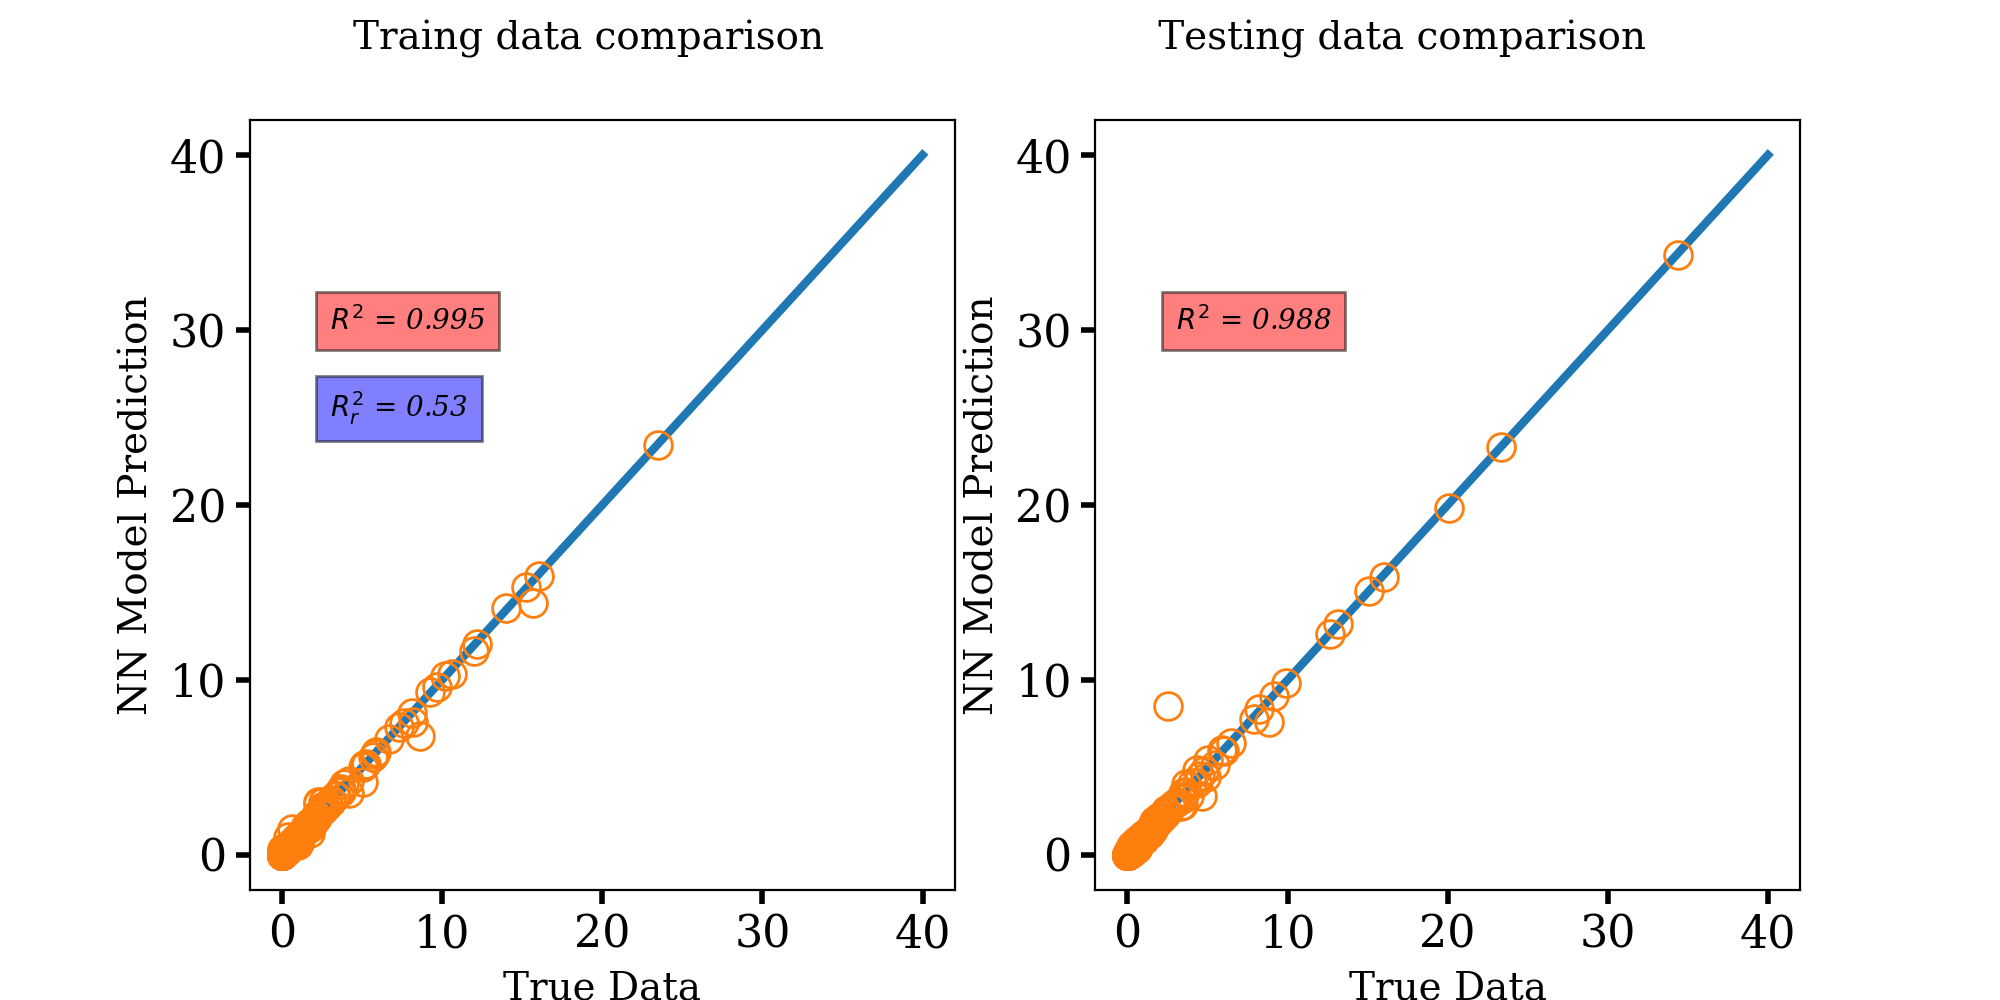

In [52]:
fig = plt.figure(figsize=(10, 5))
plt.rc('font', family='serif')

ax = fig.add_subplot(121)
plt.plot([0,40],[0,40], linewidth=3)
plt.plot(target.numpy(), output.numpy(), marker='o', markerfacecolor='None', linestyle = 'None', markersize=10)
ax = plt.gca()
ax.text(3, 30, '$R^2$ = {}'.format(str(int(1000*r2_score(output.numpy(), target.numpy()))/1000)), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})

ax.text(3, 25, '$R^2_r$ = {}'.format(str(0.53)), style='italic',
        bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 5})


plt.rc('font', family='serif')
ax.tick_params(direction='out', length=5, width=2,labelsize=16)

ax.set_xlabel('True Data', fontsize=14)
ax.set_ylabel('NN Model Prediction', fontsize=14)
# fig.suptitle('Target vs. Prediction - Training Set', fontsize=14)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 5



ax1 = fig.add_subplot(122)
plt.plot([0,40],[0,40], linewidth=3)
plt.plot(target_test.numpy(), output_test.numpy(), marker='o', markerfacecolor='None', linestyle = 'None', markersize=10)
ax1 = plt.gca()

ax1.text(3, 30, '$R^2$ = {}'.format(str(int(1000*r2_score(output_test.numpy(), target_test.numpy()))/1000)), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})

# ax1.text(3, 25, '$R^2_baseline$ = {}'.format(str(0.53)), style='italic',
#         bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 5})


plt.rc('font', family='serif')
ax1.tick_params(direction='out', length=5, width=2,labelsize=16)
fig.suptitle('Traing data comparison                           Testing data comparison', fontsize=14)


ax1.set_xlabel('True Data', fontsize=14)
ax1.set_ylabel('NN Model Prediction', fontsize=14)
ax1.xaxis.labelpad = 5
ax1.yaxis.labelpad = 5

plt.show()

### Checking a test example to draw the spectrum

In [60]:
# Data = pd.read_csv('testing_only.csv')
# Data_tensor_normalized = Data.values

In [61]:
# aa = Data_tensor_normalized[10000,0]
# bb = Data_tensor_normalized[39000,1]
# cc = Data_tensor_normalized[100,2]
# print(aa,bb,cc)

In [62]:
# test_1 = Data_tensor_normalized[Data_tensor_normalized[:,0] == aa]
# test_1 = test_1[test_1[:,1] == bb]
# test_1 = test_1[test_1[:,2] == cc]

In [63]:
# Data_tensor_test = torch.tensor(test_1).float()
# test_x = Data_tensor_test[:,0:4]
# test_y = Data_tensor_test[:,4]
# test_1_loaded = torch.utils.data.TensorDataset(test_x,test_y)
# test_1_loader = torch.utils.data.DataLoader(test_1_loaded, batch_size=bs)

In [64]:
# for batch_id, (data, target) in enumerate(test_1_loader):
#     data, target = data.to(device), target.to(device)
#     output_1 = model(data)
#     break

In [65]:
# index = np.argsort(data[:,3])
# data_test = data[index,:]
# target_test = target.numpy()[index]
# output_test = output_1.data.numpy()[index]

In [66]:
spectrum_comparison = np.loadtxt('spectrum_comparison.txt')

<IPython.core.display.Javascript object>


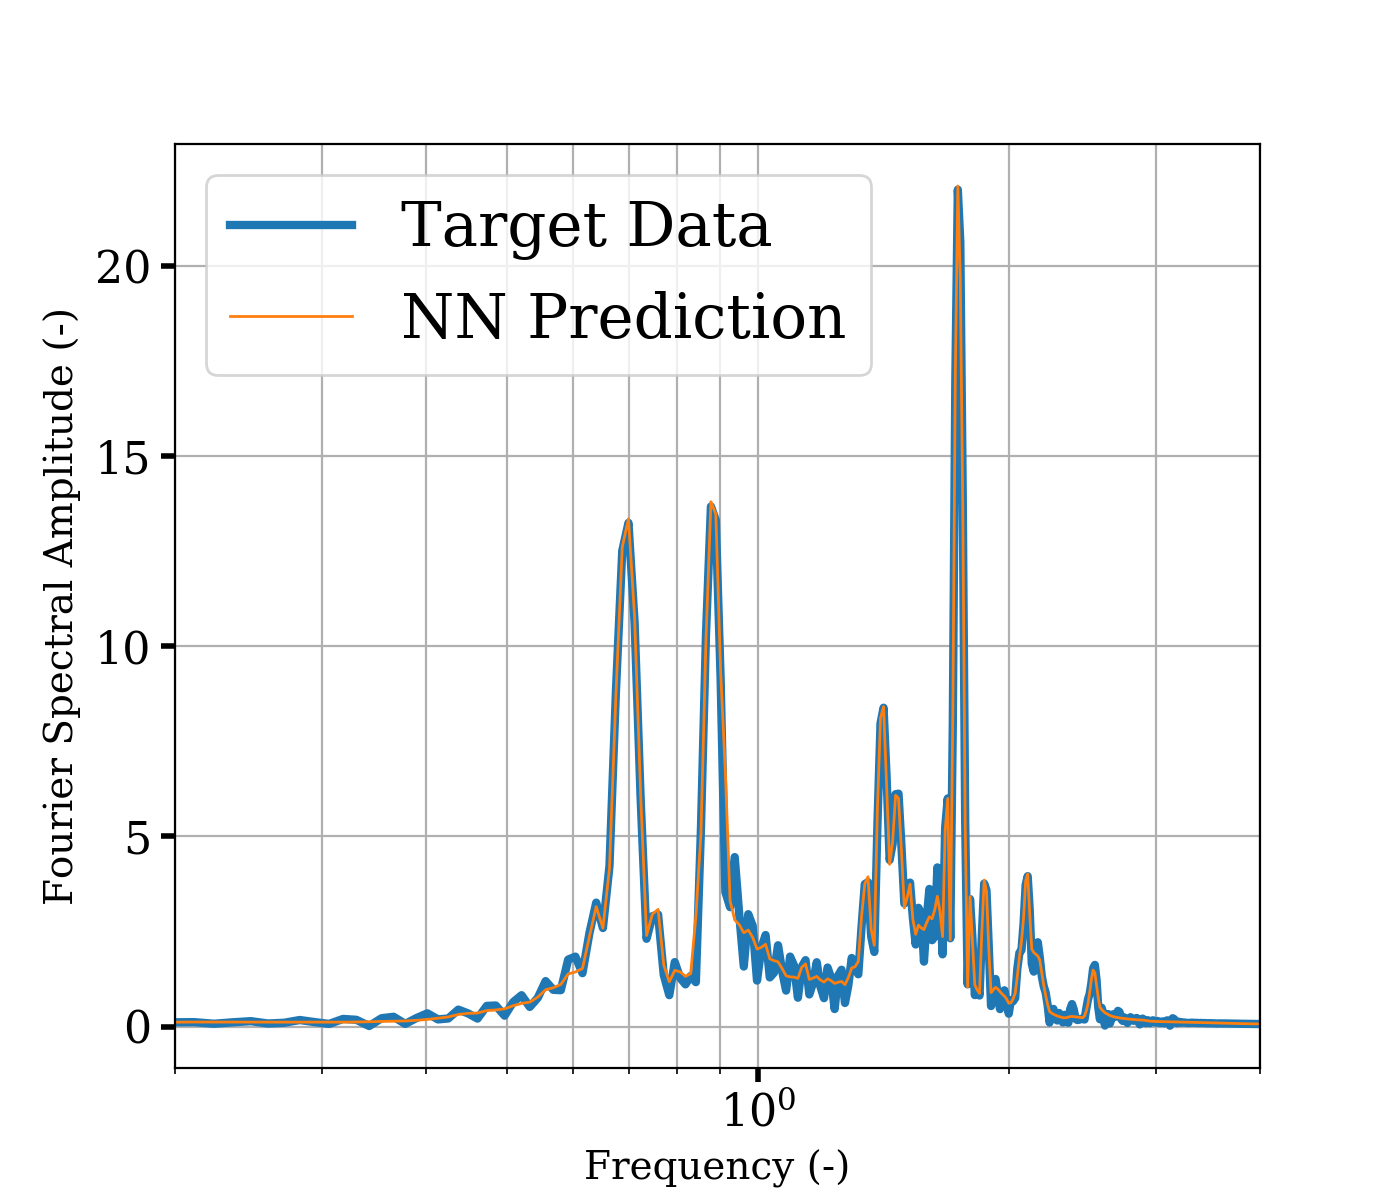

In [67]:
fig = plt.figure(figsize=(7, 6))
plt.plot(spectrum_comparison[:,0], spectrum_comparison[:,1], linewidth=3, label = 'Target Data')
plt.plot(spectrum_comparison[:,0], spectrum_comparison[:,2], linewidth=1, label = 'NN Prediction')
axes = plt.gca()

plt.rc('font', family='serif')
axes.tick_params(direction='out', length=5, width=2,labelsize=16)

axes.set_xlabel('Frequency (-)', fontsize=14)
axes.set_ylabel('Fourier Spectral Amplitude (-)', fontsize=14)
axes.xaxis.labelpad = 5
axes.yaxis.labelpad = 5
axes.set_xscale('log')
axes.set_xlim([0.2,4])
axes.grid(which='both')
plt.gca().legend(loc=0, prop={'size': 22})
plt.show()